# 2-Echelon Vehicle Routing Problem

* [Intro](#Intro)
* [Initial Setup](#init)
* [Parsing Google Places API](#places)
* [Clustering. Part 1](#cl1)
    * [Silhouette analysis for KMeans (Euclidean distances)](#sil_km)
    * [KMeans with 4 clusters](#km4)
    * [Plotting KMeans clustering on Google Maps](#km_gm)
* [Finding distance matrix](#dm)
    * [Parsing Google Distance Matrix API](#gdm)
* [Clustering. Part 2](#cl2)
    * [Agglomerative Clustering](#agl)
    * [Agglomerative Clustering for walking distances](#agl_w)
    * [Agglomerative Clustering for driving distances](#agl_dr)
* [Estimating demand of consumers](#demand)
    * [Choosing vehicles for transportation](#vehicles)
    * [Satellites locations](#sat_loc)
* [Finding optimal route for both candidate CDCs](#cdc_dist)
* [Defining transportation cost](#cost)
* [Scenario 1. 2-Echelon Single Source Location Model](#scenario_1)

<a name="intro"></a>
## Intro

This notebook researches the solution of the 2 echelon VRP in the city of Kyiv for delivery to the post offices of the Nova Poshta company.

All the data is initialized, computed and retrieved from scratch using Google Maps API and other open-source solutions.

At the moment, all the code is reproducible if the `data` folder is present. However, in the case of the need of any modifications, you will need to input your own API key for Google Maps API.

In [44]:
api_key = "<API_KEY>"

<a name="init"></a>
## Initial setup

Google Maps API only returns up to 60 results, so in order to obtain a minimum of 100 points, we would have to define two points within the city and input the same search query in an attempt to obtain the desired result.

Instead, let's define 4 points -- the borders of the researched rectangular area.

In [1]:
bl = (50.381347, 30.442942)
tl = (50.533611, 30.442942)
tr = (50.533611, 30.65)
br = (50.381347, 30.65)

borders = {"bl": bl,
           "tl": tl,
           "tr": tr,
           "br": br}

The distances between the two diagonals (`bl` <-> `tr` & `br` <-> `tl`) is approximately 22 km.

In order to get the most results, we need to specify circles halfway to the center with the diameter of half the diagonal. This will result in some overlapping, but the whole area will be covered.

Moreover, we will drop the results with coordinates above or below the defined rectangle to ensure we only consider customers within the rectangle.

In [2]:
import numpy as np

In [3]:
c1 = (bl[0] + (tr[0] - bl[0]) / 4, bl[1] + (tr[1] - bl[1]) / 4)
c2 = (bl[0] + (tr[0] - bl[0]) / 4 * 3, bl[1] + (tr[1] - bl[1]) / 4 * 3)
c3 = (tl[0] + (br[0] - tl[0]) / 4, br[1] + (tl[1] - br[1]) / 4 * 3)
c4 = (tl[0] + (br[0] - tl[0]) / 4 * 3, br[1] + (tl[1] - br[1]) / 4)

r1 = np.linalg.norm(np.array(bl) - np.array(tr)) / 4
r2 = np.linalg.norm(np.array(br) - np.array(tl)) / 4

centers = {"c1": c1,
           "c2": c2,
           "c3": c3,
           "c4": c4}

In [4]:
import matplotlib.pyplot as plt

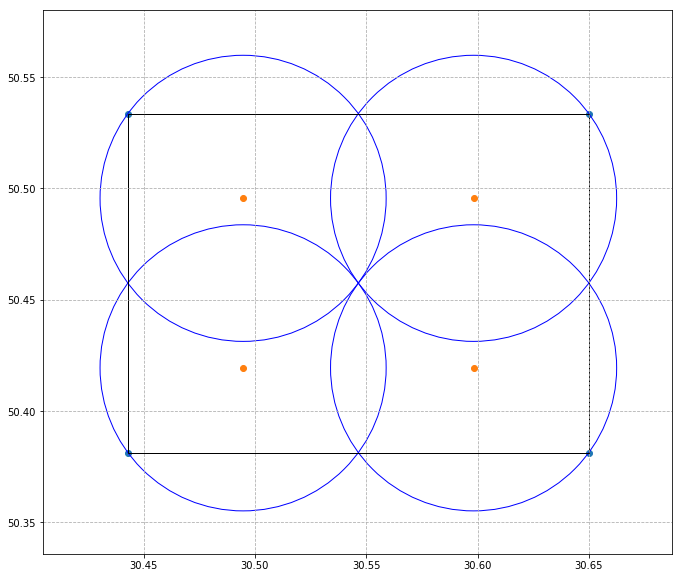

In [5]:
plt.figure(figsize=(20,10))
ax = plt.gca()
ax.cla()
plt.grid(linestyle='--')
plt.xlim(centers['c1'][1] - r1*1.4, centers['c1'][1] + r1*3)
plt.ylim(centers['c1'][0] - r1*1.3, centers['c1'][0] + r1*2.5)
circle1 = plt.Circle((centers['c1'][1], centers['c1'][0]), r1, color = 'blue', fill = False)
circle2 = plt.Circle((centers['c2'][1], centers['c2'][0]), r1, color = 'blue', fill = False)
circle3 = plt.Circle((centers['c3'][1], centers['c3'][0]), r2, color = 'blue', fill = False)
circle4 = plt.Circle((centers['c4'][1], centers['c4'][0]), r2, color = 'blue', fill = False)
rectangle = plt.Rectangle((bl[1], bl[0]), width = tr[1] - tl[1], height = tr[0] - br[0], fill = False, color = "black")
ax.set_aspect(1)
ax.scatter(*zip(*[(x, y) for (y, x) in borders.values()]))
ax.scatter(*zip(*[(x, y) for (y, x) in centers.values()]))

ax.add_artist(circle1)
ax.add_artist(circle2)
ax.add_artist(circle3)
ax.add_artist(circle4)
ax.add_artist(rectangle)
plt.show()

In [6]:
from math import sin, cos, sqrt, atan2, radians

# approximate radius of earth in km
R = 6373.0

lat1 = radians(bl[0])
lon1 = radians(bl[1])
lat2 = radians(tr[0])
lon2 = radians(tr[1])

dlon = lon2 - lon1
dlat = lat2 - lat1

a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
c = 2 * atan2(sqrt(a), sqrt(1 - a))

distance = R * c

print(f"The diagonals of the rectagle are {distance:.2f} km.")

The diagonals of the rectagle are 22.40 km.


In [7]:
radius = distance / 4 * 1e3
print(f"The radius of each circle is {radius:.0f} m.")

The radius of each circle is 5600 m.


<a name="places"></a>
## Parsing Google Places API

In [8]:
from time import time, sleep
import pandas as pd
import googlemaps

In [9]:
loc_parsed_df = 'data/parsed_np.csv'

In [10]:
try:
    df = pd.read_csv(loc_parsed_df)
except:
    gmaps = googlemaps.Client(key = api_key)
    del df
    for center in centers.keys():
        print(centers[center])
        has_next_page = True
        first_page = True
        while has_next_page:
            if first_page:
                response = gmaps.places(query = "nova poshta", location = centers[center], radius = radius)
                first_page = False
            else:
                response = gmaps.places(query = "nova poshta", location = centers[center], radius = radius, page_token = next_page_token)
            try:
                next_page_token = response["next_page_token"]
                print(next_page_token)
            except:
                has_next_page = False
            try:
                df = pd.concat([df, pd.DataFrame(response['results'])])
            except:
                df = pd.DataFrame(response['results'])
            print(df.shape)
            sleep(5)
    df.drop_duplicates(subset = 'formatted_address', inplace = True)
df.head()

,formatted_address,geometry,icon,id,name,opening_hours,photos,place_id,plus_code,rating,reference,types,user_ratings_total
0,"Saksahanskoho St, 76, Kyiv, Ukraine, 01032","{'location': {'lat': 50.44027639999999, 'lng':...",https://maps.gstatic.com/mapfiles/place_api/ic...,1d972a04859d4fab983732eccad4c6dd411a9c7d,Nova Poshta,{'open_now': True},"[{'height': 4160, 'html_attributions': ['<a hr...",ChIJHw_UA_HO1EARC2d-Q4YGvBg,"{'compound_code': 'CGR2+4G Kyiv, Kyiv city', '...",3.8,ChIJHw_UA_HO1EARC2d-Q4YGvBg,"['post_office', 'finance', 'point_of_interest'...",417
1,"Київ, Бульварно-Кудрявська, ран. Воровського, ...","{'location': {'lat': 50.450083, 'lng': 30.4962...",https://maps.gstatic.com/mapfiles/place_api/ic...,1b10a884a4808f76fd0784247e54989c458a656f,Nova Poshta,{'open_now': True},"[{'height': 3456, 'html_attributions': ['<a hr...",ChIJT1wtIGDO1EARDscyDRzUTPA,"{'compound_code': 'FF2W+2F Kyiv, Kyiv city', '...",4.3,ChIJT1wtIGDO1EARDscyDRzUTPA,"['point_of_interest', 'establishment']",192
2,"Preobrazhenska St, 8б, Kyiv, Ukraine, 03037","{'location': {'lat': 50.4242448, 'lng': 30.472...",https://maps.gstatic.com/mapfiles/place_api/ic...,e3d7c7406b127e42cec679d222035d549118d596,Nova Poshta №240,{'open_now': True},"[{'height': 1080, 'html_attributions': ['<a hr...",ChIJTw2tusfO1EARWh7P_e6if-o,"{'compound_code': 'CFFC+MX Kyiv, Kyiv city', '...",4.2,ChIJTw2tusfO1EARWh7P_e6if-o,"['point_of_interest', 'establishment']",595
3,"маг.""Фуршет, Lesi Ukrainky Blvd, 5, Kyiv, Ukra...","{'location': {'lat': 50.4352113, 'lng': 30.530...",https://maps.gstatic.com/mapfiles/place_api/ic...,c0e0477b2ad6ba0fea0f41a79352459471502f3e,Nova Poshta,{'open_now': True},"[{'height': 2448, 'html_attributions': ['<a hr...",ChIJk2oxTQHP1EARKlmkVD6n2PU,"{'compound_code': 'CGPJ+33 Kyiv, Kyiv city', '...",4.0,ChIJk2oxTQHP1EARKlmkVD6n2PU,"['point_of_interest', 'establishment']",115
4,"Київ, Шота Руставелі, 31а (м. ""Палац спорту, K...","{'location': {'lat': 50.4372615, 'lng': 30.518...",https://maps.gstatic.com/mapfiles/place_api/ic...,a28abba3956efb2bc79f6701bfaaf68776906d16,Nova Poshta,{'open_now': True},"[{'height': 3264, 'html_attributions': ['<a hr...",ChIJm9qlhf7O1EARZQ5CXQ2Cgy0,"{'compound_code': 'CGP9+WG Kyiv, Kyiv city', '...",4.2,ChIJm9qlhf7O1EARZQ5CXQ2Cgy0,"['point_of_interest', 'establishment']",146


In [11]:
print(f"A total of {len(df['formatted_address'].unique())} post offices were found within the 4 circles.")

A total of 135 post offices were found within the 4 circles.


In [12]:
df.reset_index(drop = True, inplace = True)
df.to_csv(loc_parsed_df, header = True, index = False)

In [13]:
import ast

df['lat'] = df['geometry'].apply(lambda x: ast.literal_eval(x)['location']['lat'])
df['lon'] = df['geometry'].apply(lambda x: ast.literal_eval(x)['location']['lng'])

In [14]:
df['in_square'] = ((df['lat'] > bl[0]) & (df['lat'] < tr[0]) & (df['lon'] > bl[1]) & (df['lon'] < tr[1]))

In [15]:
print(f"A total of {len(df['formatted_address'][df['in_square']].unique())} post offices found are within the considered rectangle.")

A total of 118 post offices found are within the considered rectangle.


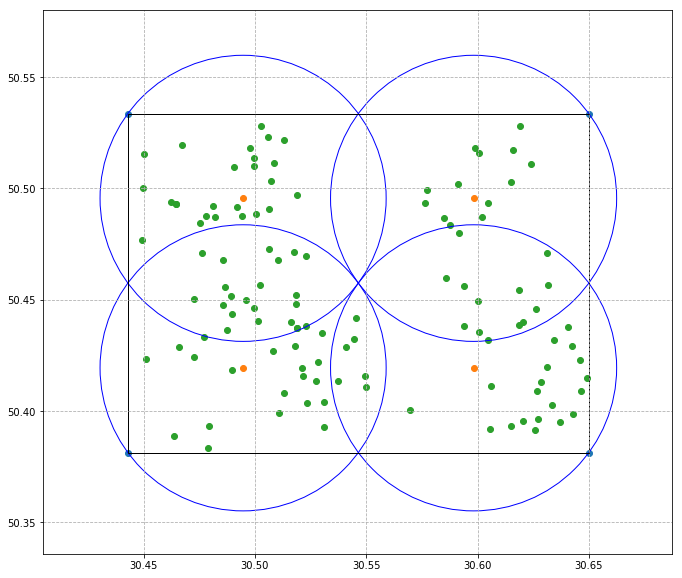

In [16]:
plt.figure(figsize=(20,10))
ax = plt.gca()
ax.cla()
plt.grid(linestyle='--')
plt.xlim(centers['c1'][1] - r1*1.4, centers['c1'][1] + r1*3)
plt.ylim(centers['c1'][0] - r1*1.3, centers['c1'][0] + r1*2.5)
circle1 = plt.Circle((centers['c1'][1], centers['c1'][0]), r1, color = 'blue', fill = False)
circle2 = plt.Circle((centers['c2'][1], centers['c2'][0]), r1, color = 'blue', fill = False)
circle3 = plt.Circle((centers['c3'][1], centers['c3'][0]), r2, color = 'blue', fill = False)
circle4 = plt.Circle((centers['c4'][1], centers['c4'][0]), r2, color = 'blue', fill = False)
rectangle = plt.Rectangle((bl[1], bl[0]), width = tr[1] - tl[1], height = tr[0] - br[0], fill = False, color = "black")
ax.set_aspect(1)
ax.scatter(*zip(*[(x, y) for (y, x) in borders.values()]))
ax.scatter(*zip(*[(x, y) for (y, x) in centers.values()]))

ax.scatter(df['lon'][df['in_square']], df['lat'][df['in_square']])

ax.add_artist(circle1)
ax.add_artist(circle2)
ax.add_artist(circle3)
ax.add_artist(circle4)
ax.add_artist(rectangle)
plt.show()

<a name="cl1"></a>
## Clustering

Let's analyze what amount of clusters is best fit for the given data points.

We will use K-means algorithm, which uses the Euclidean metric for the pairwise distance, thus there will most likely be non-optimal cluster assignments.

Let's perform the Silhouette analysis for cluster numbers from 2 to 6. 1 is redundant and everything above 6 is not viable for our considered task.

In [17]:
clusters_df = df[['lat', 'lon', 'user_ratings_total', 'rating']][df['in_square']]
clusters_df['user_ratings_total_scaled'] = clusters_df['user_ratings_total'] / clusters_df['user_ratings_total'].max()
clusters_df['weighted_ratings'] = clusters_df['rating'] * clusters_df['user_ratings_total'] / (clusters_df['rating'] * clusters_df['user_ratings_total']).max()
clusters_df.head()

,lat,lon,user_ratings_total,rating,user_ratings_total_scaled,weighted_ratings
0,50.440276,30.501372,417,3.8,0.319540,0.296159
1,50.450083,30.496220,192,4.3,0.147126,0.154303
2,50.424245,30.472491,595,4.2,0.455939,0.467059
3,50.435211,30.530175,115,4.0,0.088123,0.085973
4,50.437261,30.518789,146,4.2,0.111877,0.114606


<a name="sil_km"></a>
### Silhouette analysis for KMeans (Euclidean distances)

In [18]:
X = clusters_df[['lat', 'lon']]

For n_clusters = 2 The average silhouette_score is : 0.5313525718118249
For n_clusters = 3 The average silhouette_score is : 0.47991360883988454
For n_clusters = 4 The average silhouette_score is : 0.4984763926878794
For n_clusters = 5 The average silhouette_score is : 0.47953602643476456
For n_clusters = 6 The average silhouette_score is : 0.45717502982804253


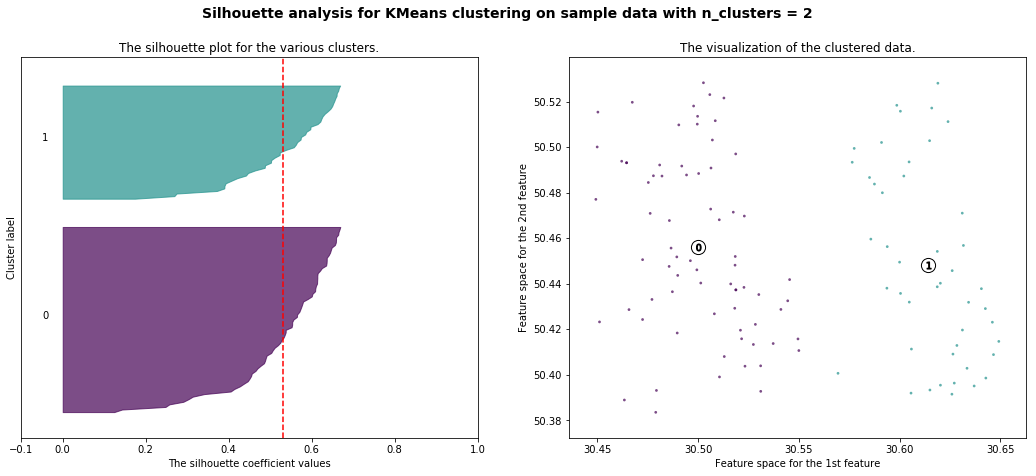

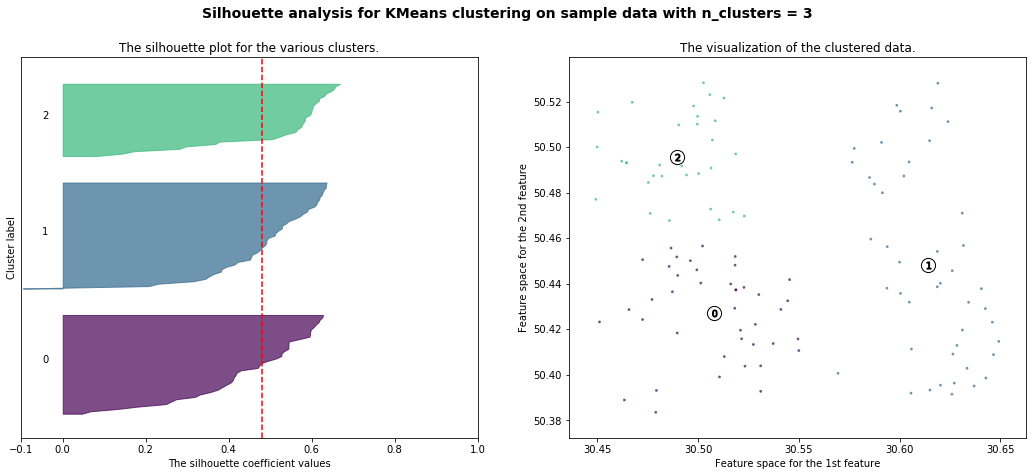

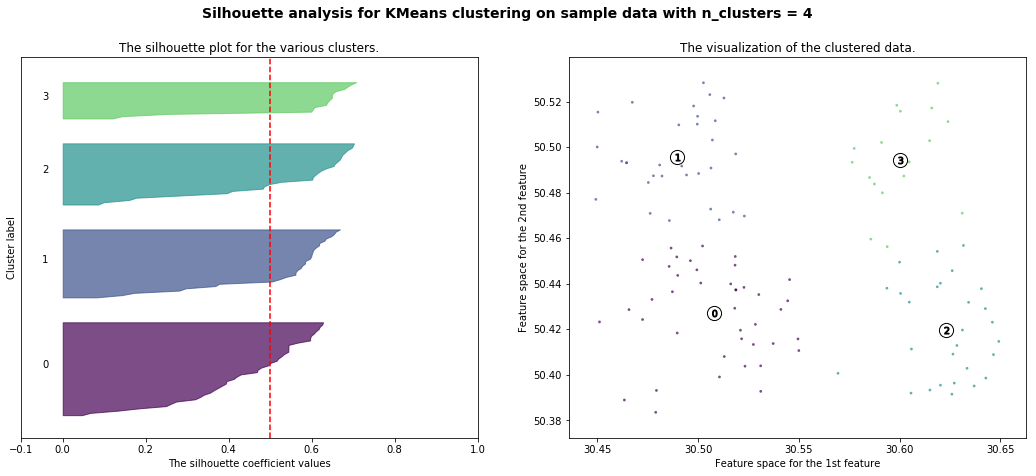

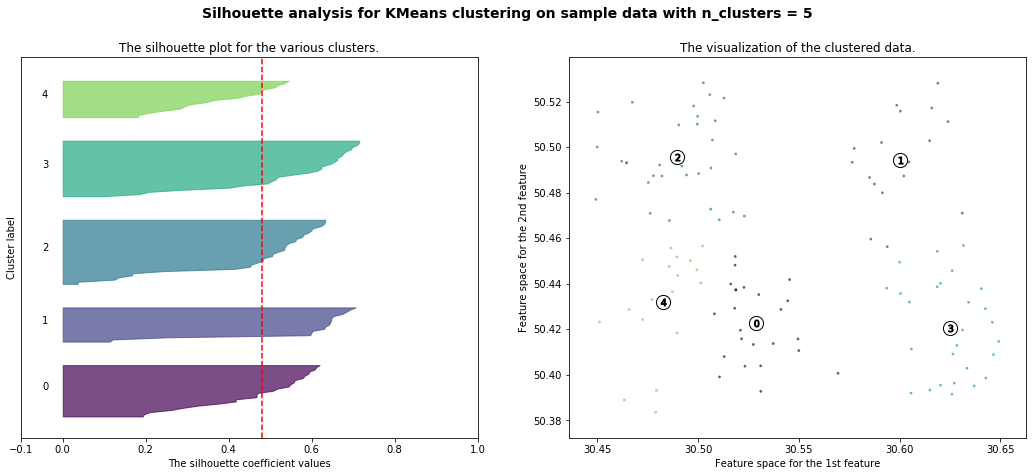

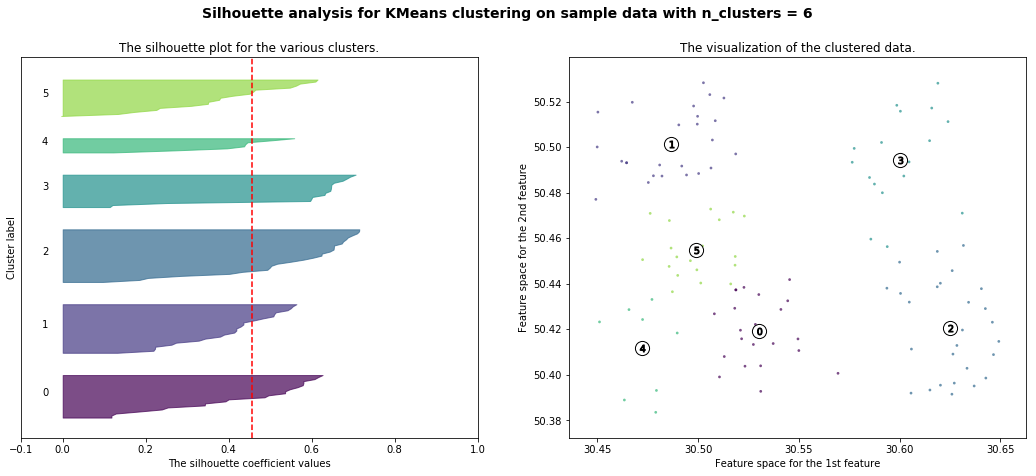

In [19]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Defining a range of clusters to search in
range_n_clusters = range(2, 7, 1)

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(clusters_df) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.viridis(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.viridis(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X.iloc[:, 1], X.iloc[:, 0], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    center_points = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(center_points[:, 1], center_points[:, 0], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(center_points):
        ax2.scatter(c[1], c[0], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

As Silhouette analysis demonstrates, 4 is the optimal number of clusters to break down the data points. We will not be using 2 as another oversimplistic version.

<a name="km4"></a>
### KMeans with 4 clusters

In [20]:
from matplotlib.cm import viridis
from matplotlib.colors import to_hex

In [21]:
def calculate_color(clust):
    """
    Convert cluster number to a color
    """
    # transform the gini coefficient to a matplotlib color
    mpl_color = viridis(clust / num_clusters)

    # transform from a matplotlib color to a valid CSS color
    gmaps_color = to_hex(mpl_color, keep_alpha = False)

    return gmaps_color

In [22]:
num_clusters = 4
kmeans = KMeans(n_clusters = num_clusters).fit(clusters_df[['lat', 'lon']])
centroids = kmeans.cluster_centers_
print(centroids)

[[50.42705734 30.50797268]
 [50.41978153 30.62298615]
 [50.49543372 30.48969494]
 [50.4944713  30.60000928]]


In [23]:
clusters_df['cluster'] = kmeans.labels_
clusters_df['color'] = clusters_df['cluster'].apply(calculate_color)
clusters_df.head()

,lat,lon,user_ratings_total,rating,user_ratings_total_scaled,weighted_ratings,cluster,color
0,50.440276,30.501372,417,3.8,0.319540,0.296159,0,#440154
1,50.450083,30.496220,192,4.3,0.147126,0.154303,0,#440154
2,50.424245,30.472491,595,4.2,0.455939,0.467059,0,#440154
3,50.435211,30.530175,115,4.0,0.088123,0.085973,0,#440154
4,50.437261,30.518789,146,4.2,0.111877,0.114606,0,#440154


<a name="km_gm"></a>
### Plot of KMeans clustering on Google Maps

In [24]:
import gmaps

In [45]:
gmaps.configure(api_key = api_key)

In [46]:
lat = bl[0] + (tr[0] - bl[0]) / 2
lon = bl[1] + (tr[1] - bl[1]) / 2
print(f"Plotting the map centered at ({lat:.4f}, {lon:.4f}).")

Plotting the map centered at (50.4575, 30.5465).


In [47]:
figure_layout = {
    'width': '800px',
    'height': '800px',
    'border': '1px solid black',
    'padding': '1px'
}
zoom = 12

In [48]:
fig = gmaps.figure(center = (lat, lon), zoom_level = zoom, layout=figure_layout)
for clust in clusters_df['cluster'].unique():
    cluster_layer = gmaps.symbol_layer(
        clusters_df[['lat', 'lon']][clusters_df['cluster'] == clust],
        fill_color = clusters_df['color'][clusters_df['cluster'] == clust].iloc[0],
        stroke_color = clusters_df['color'][clusters_df['cluster'] == clust].iloc[0],
        scale = 3
    )
    fig.add_layer(cluster_layer)

centers_layer = gmaps.symbol_layer(
        kmeans.cluster_centers_,
        fill_color = "#ff007f",
        stroke_color = "#ff007f",
        scale = 5)
fig.add_layer(centers_layer)

fig

Figure(layout=FigureLayout(border='1px solid black', height='800px', padding='1px', width='800px'))

Plotting weighted ratings of the post offices colored in the colors of one of the 4 assigned.


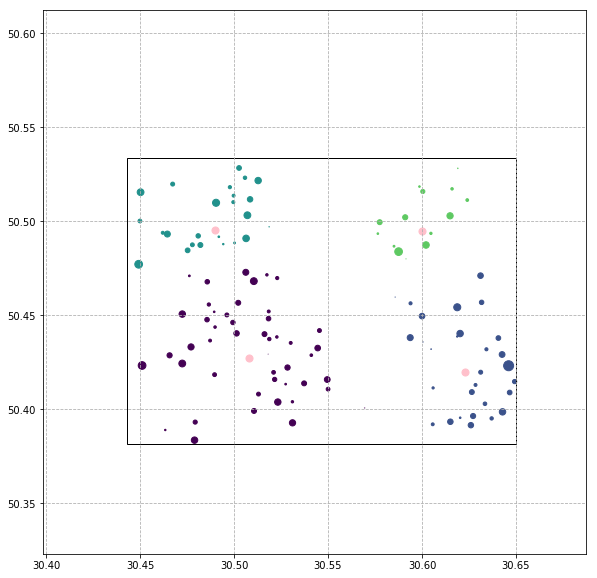

In [49]:
print(f"Plotting weighted ratings of the post offices colored in the colors of one of the {n_clusters} assigned.")
plt.figure(figsize=(20,10))
ax = plt.gca()
ax.cla()
plt.grid(linestyle='--')
plt.ylim(centers['c1'][0] - r1*1.5, centers['c1'][0] + r1*3)
plt.xlim(centers['c1'][1] - r1*1.5, centers['c1'][1] + r1*3)
rectangle = plt.Rectangle((bl[1], bl[0]), width = tr[1] - tl[1], height = tr[0] - br[0], fill = False, color = "black")
ax.set_aspect(1)
size_series = clusters_df['weighted_ratings'] * 100
ax.scatter(clusters_df['lon'], clusters_df['lat'], s = size_series, c = clusters_df['color'])
ax.scatter(centroids[:, 1], centroids[:, 0], c='pink', s=50)
ax.add_artist(rectangle)
plt.show()

<a name="dm"></a>
## Finding distance matrix

In [50]:
from tqdm import tqdm_notebook as tqdm

<a name="gdm"></a>
### Parsing Google Distance Matrix API

#### Parsing GDM to obtain driving distances

In [51]:
loc_dist_matrix = "data/distances_driving.npy"

In [52]:
try:
    matrix_driving = np.load(loc_dist_matrix)
except:
    matrix_driving = np.empty((len(clusters_df), len(clusters_df)))
    columns = len(clusters_df)
    gmaps_api = googlemaps.Client(key = api_key)
    for row in tqdm(range(len(clusters_df))):
        for column in tqdm(range(columns)):
            origins = (clusters_df['lat'].iloc[row], clusters_df['lon'].iloc[row])
            destination = (clusters_df['lat'].iloc[column], clusters_df['lon'].iloc[column])
            distance = gmaps_api.distance_matrix(origins, destination, mode='driving')["rows"][0]["elements"][0]["distance"]["value"]
            matrix_driving[row, column] = distance
        sleep(5)
    np.save(loc_dist_matrix, matrix_driving)

In [53]:
matrix_driving

array([[    0.,  1418.,  3594., ..., 12426.,  5902., 13264.],
       [ 2089.,     0.,  4617., ..., 13224.,  6975., 14506.],
       [ 4017.,  4679.,     0., ..., 13393.,  6868., 14231.],
       ...,
       [12197., 11940., 13259., ...,     0.,  9991.,  7167.],
       [ 6578.,  7397.,  9117., ...,  6652.,     0.,  7491.],
       [13976., 12427., 14584., ...,  8400., 11491.,     0.]])

#### Parsing GDM to obtain walking distances

In [54]:
loc_dist_matrix_walking = "data/distances_walking.npy"

In [55]:
try:
    matrix_walking = np.load(loc_dist_matrix_walking)
except:
    matrix_walking = np.empty((len(clusters_df), len(clusters_df)))
    columns = len(clusters_df)
    gmaps_api = googlemaps.Client(key = api_key)
    for row in tqdm(range(len(clusters_df))):
        for column in tqdm(range(columns)):
            origins = (clusters_df['lat'].iloc[row], clusters_df['lon'].iloc[row])
            destination = (clusters_df['lat'].iloc[column], clusters_df['lon'].iloc[column])
            distance = gmaps_api.distance_matrix(origins, destination, mode='walking')["rows"][0]["elements"][0]["distance"]["value"]
            matrix_walking[row, column] = distance
        sleep(5)
    np.save(loc_dist_matrix_walking, matrix_walking)

In [56]:
matrix_walking

array([[    0.,  1418.,  3245., ...,  9535.,  4962., 10791.],
       [ 1418.,     0.,  4228., ..., 10231.,  6380., 11488.],
       [ 3245.,  4256.,     0., ..., 10958.,  6634., 13177.],
       ...,
       [ 9699., 10262., 10780., ...,     0.,  5343.,  9507.],
       [ 4934.,  6352.,  6607., ...,  5343.,     0.,  7467.],
       [10973., 11536., 13195., ...,  9507.,  7467.,     0.]])

<a name="cl2"></a>
## Clustering. Part 2

Now that we have obtained the true distance matrices for driving and walking instead of Euclidean distance metric, we can now compute a more accurate clustering distribution.

However, `sklearn` does not have KMeans clustering for custom distribution matrices, and thus we ought to seek some other clustering technique.

Let's first take a look at a fairly popular clustering algorithm, OPTICS:

### OPTICS

In [1]:
from sklearn.cluster import OPTICS

ImportError: cannot import name 'OPTICS'

In [ ]:
X = matrix_walking

In [39]:
clust = OPTICS(min_samples = 10, xi=.05, min_cluster_size=.05)
clust.fit(X)

NameError: name 'OPTICS' is not defined

In [40]:
set(clust.labels_)

AttributeError: 'numpy.int64' object has no attribute 'labels_'

In [41]:
clusters_df['cluster'] = clust.labels_
clusters_df['color'] = clusters_df['cluster'].apply(calculate_color)
clusters_df.head()

AttributeError: 'numpy.int64' object has no attribute 'labels_'

In [43]:
fig = gmaps.figure(center = (lat, lon), zoom_level = zoom, layout=figure_layout)
for clust in clusters_df['cluster'].unique():
    cluster_layer = gmaps.symbol_layer(
        clusters_df[['lat', 'lon']][clusters_df['cluster'] == clust],
        fill_color = clusters_df['color'][clusters_df['cluster'] == clust].iloc[0],
        stroke_color = clusters_df['color'][clusters_df['cluster'] == clust].iloc[0],
        scale = 3
    )
    fig.add_layer(cluster_layer)

fig

Figure(layout=FigureLayout(border='1px solid black', height='800px', padding='1px', width='800px'))

As observed in the plotted image, the algorithm performs rather poorly on the data points provided. Thus, we continue our quest for a better clustering instrument to obtain clusters. Our next candidate is Agglomerative Clustering.

<a name="agl"></a>
### Agglomerative Clustering

Unlike OPTICS, Agglomerative Clustering algorithm requires the number of clusters to be provided explicitly. Thus, we resort to Silhouette analysis once again to determine the optimal number of clusters.

#### Silhouette analysis for walking distances

In [57]:
X = matrix_walking

For n_clusters = 2 The average silhouette_score is : 0.47464123112016526
For n_clusters = 3 The average silhouette_score is : 0.4905534458244634
For n_clusters = 4 The average silhouette_score is : 0.5387711559407464
For n_clusters = 5 The average silhouette_score is : 0.47346922377244854
For n_clusters = 6 The average silhouette_score is : 0.4677147946916763
For n_clusters = 7 The average silhouette_score is : 0.48649718955729765
For n_clusters = 8 The average silhouette_score is : 0.45163784828291303
For n_clusters = 9 The average silhouette_score is : 0.4597822151527626
For n_clusters = 10 The average silhouette_score is : 0.44798708064541476


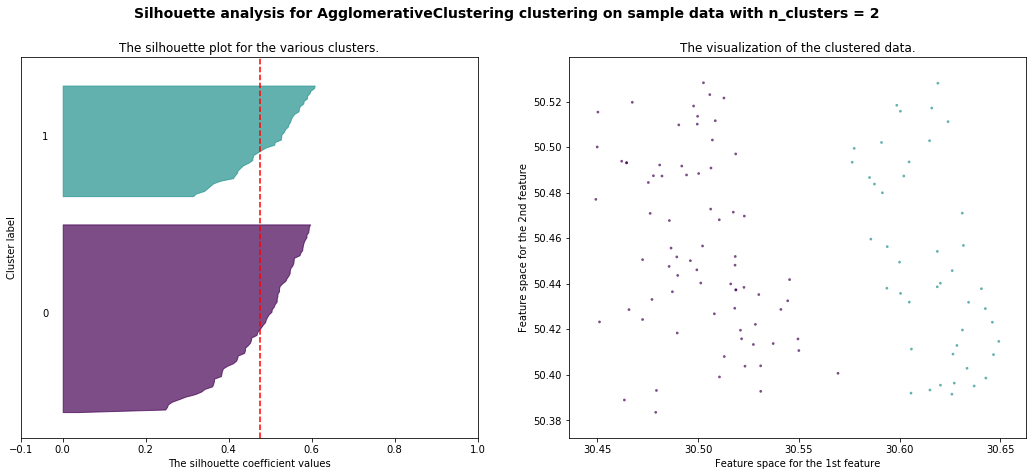

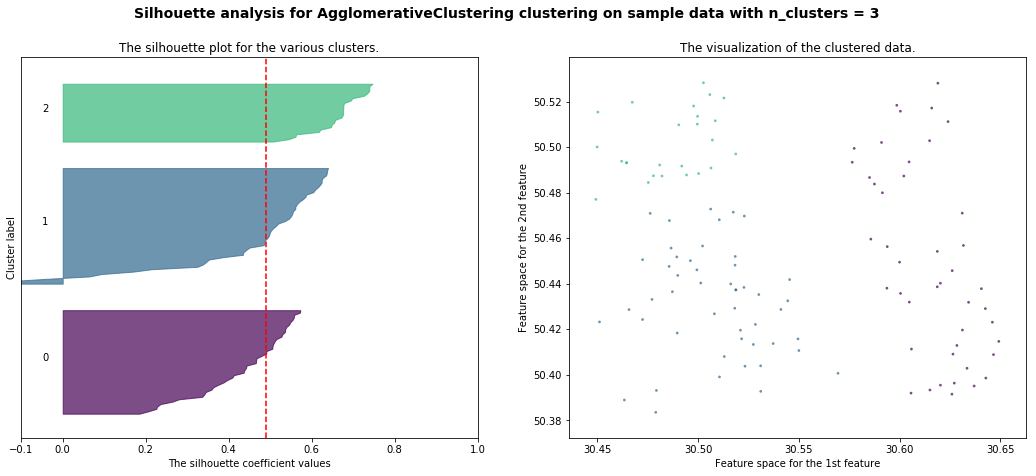

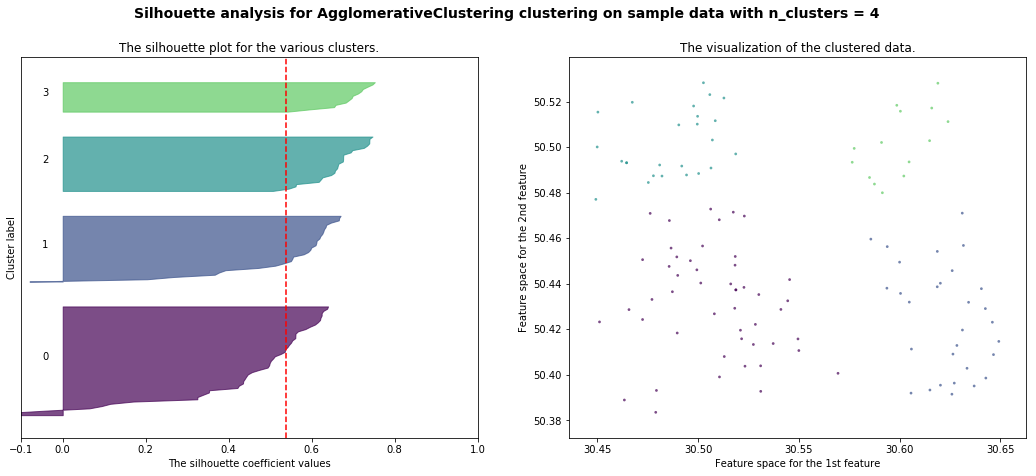

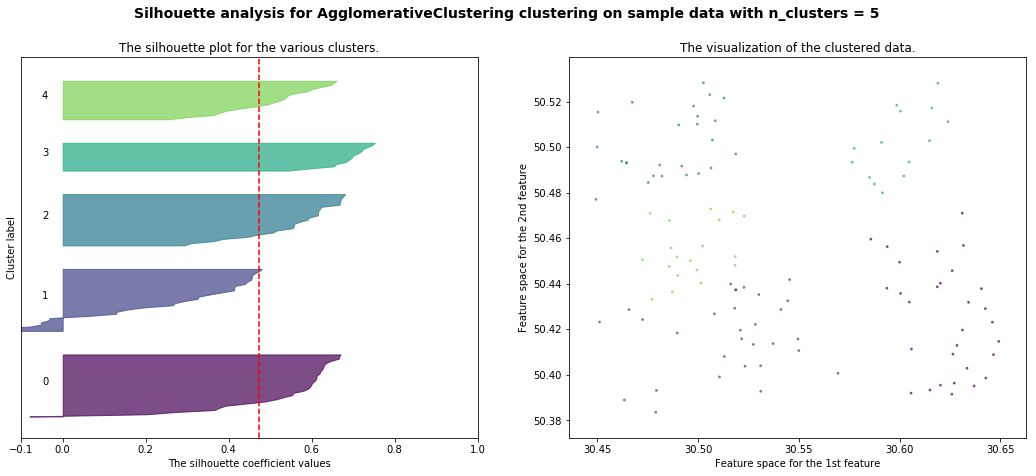

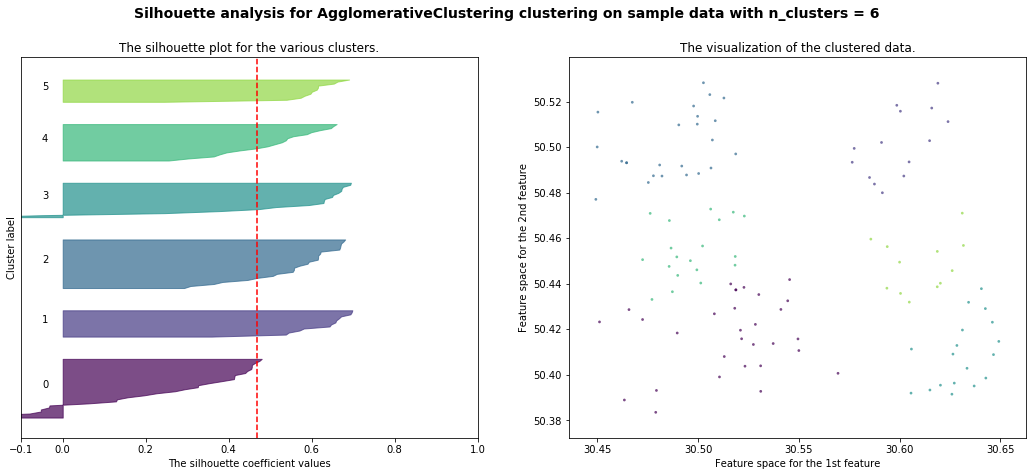

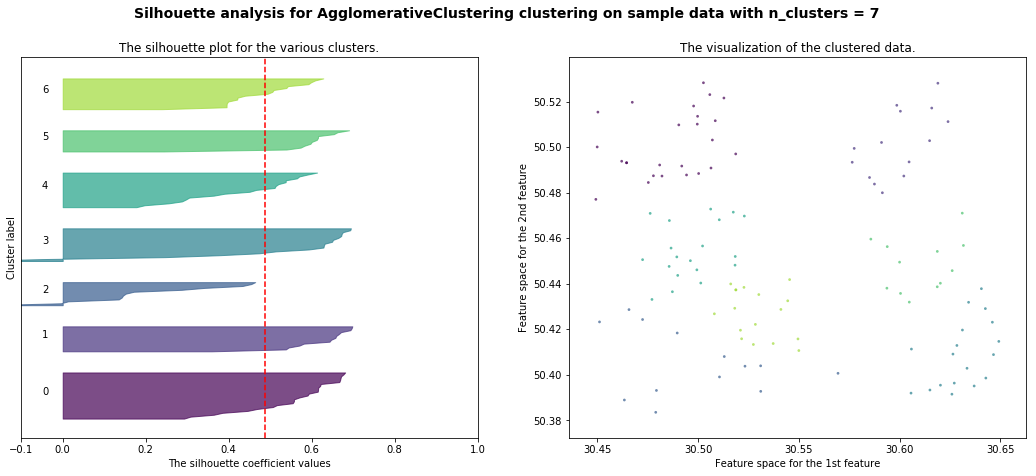

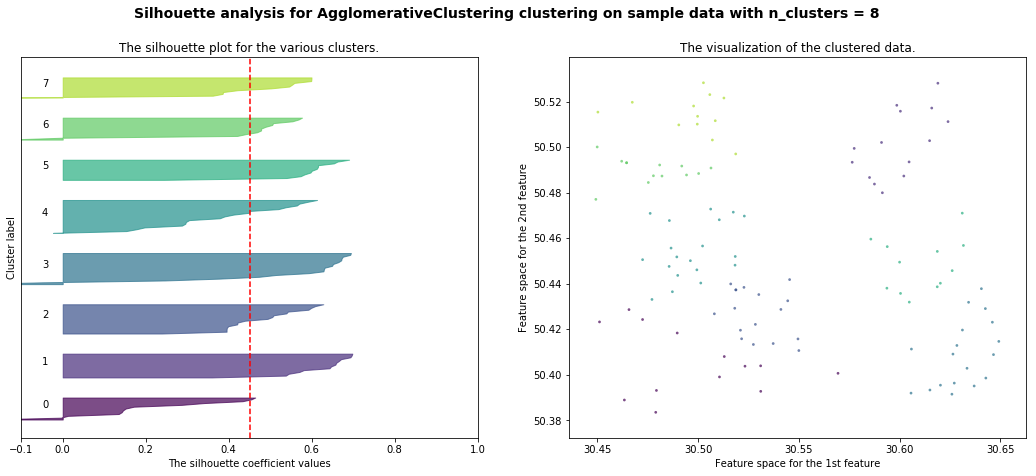

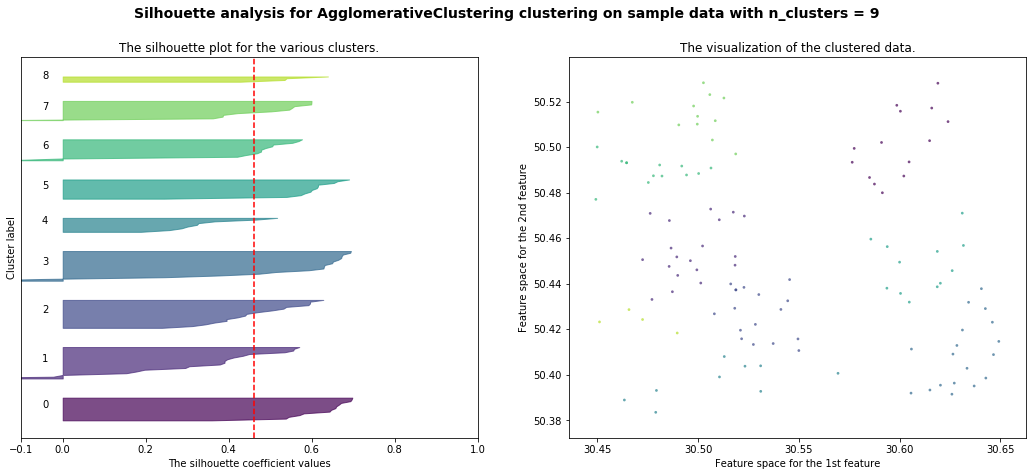

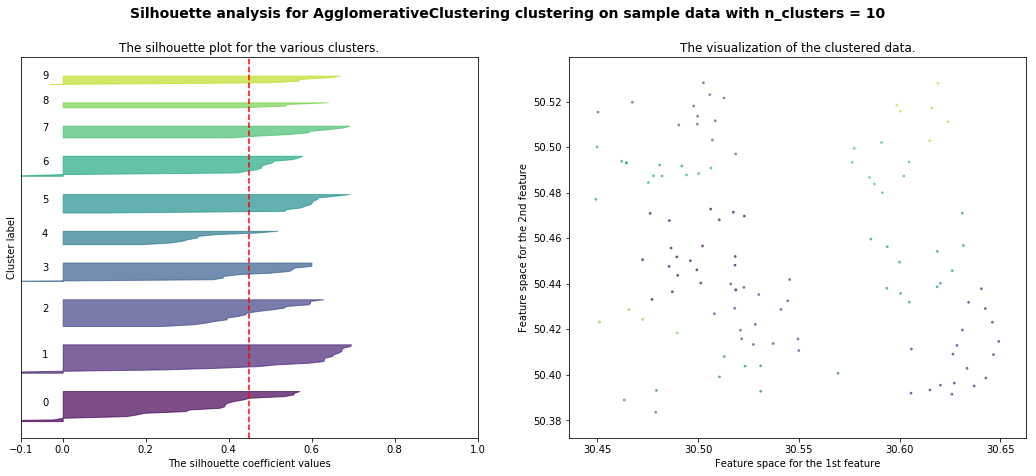

In [58]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.

range_n_clusters = range(2, 11, 1)

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = AgglomerativeClustering(n_clusters = n_clusters).fit(X)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.viridis(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.viridis(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(clusters_df[['lat', 'lon']].iloc[:, 1], clusters_df[['lat', 'lon']].iloc[:, 0], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
#     centers = clusterer.cluster_centers_
#     # Draw white circles at cluster centers
#     ax2.scatter(centers[:, 1], centers[:, 0], marker='o',
#                 c="white", alpha=1, s=200, edgecolor='k')

#     for i, c in enumerate(centers):
#         ax2.scatter(c[1], c[0], marker='$%d$' % i, alpha=1,
#                     s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for AgglomerativeClustering clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

#### Silhouette analysis for driving distances

In [59]:
X = matrix_driving

For n_clusters = 2 The average silhouette_score is : 0.3821315755233003
For n_clusters = 3 The average silhouette_score is : 0.4294077237548883
For n_clusters = 4 The average silhouette_score is : 0.4646955777488318
For n_clusters = 5 The average silhouette_score is : 0.4316577616249155
For n_clusters = 6 The average silhouette_score is : 0.4511081139176247
For n_clusters = 7 The average silhouette_score is : 0.4239611414912252
For n_clusters = 8 The average silhouette_score is : 0.41383346250153585
For n_clusters = 9 The average silhouette_score is : 0.4091470620804474
For n_clusters = 10 The average silhouette_score is : 0.38438344857638174


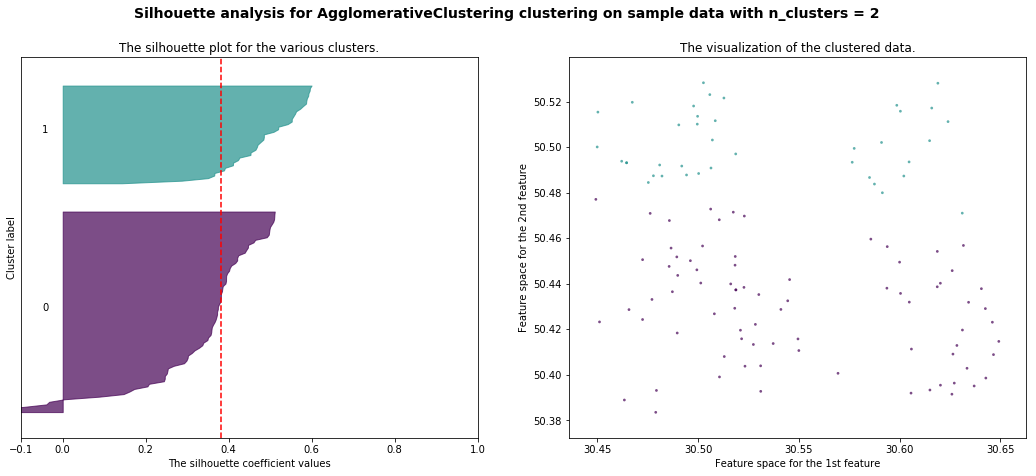

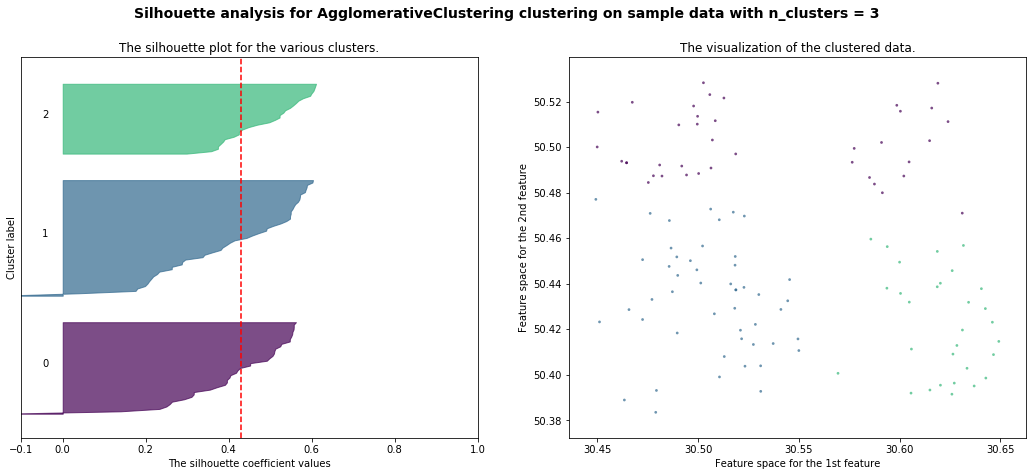

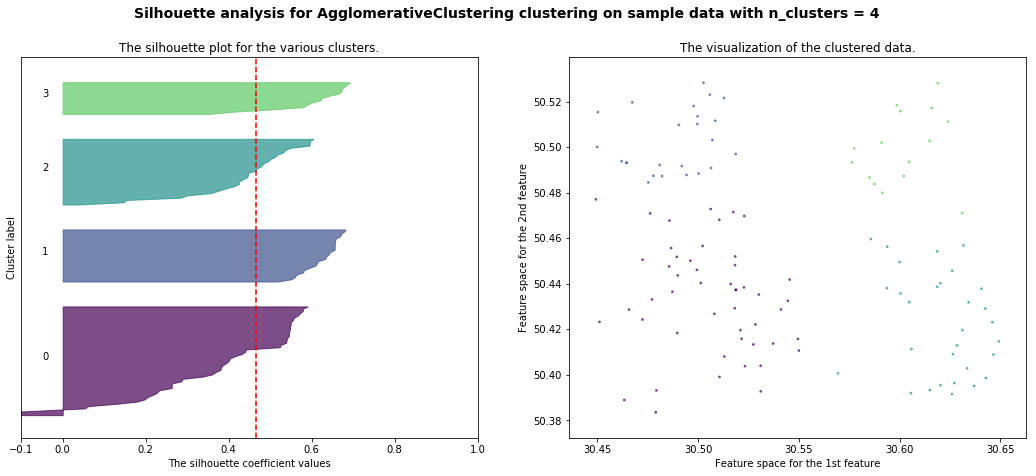

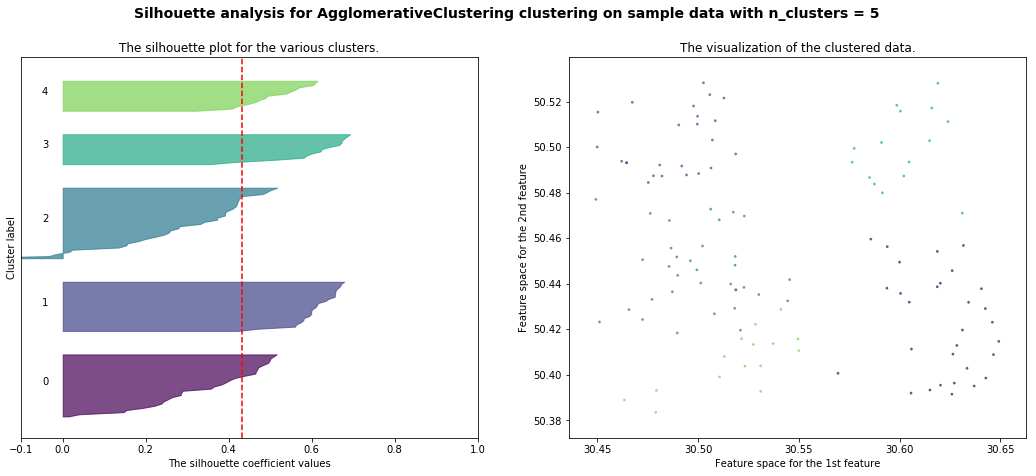

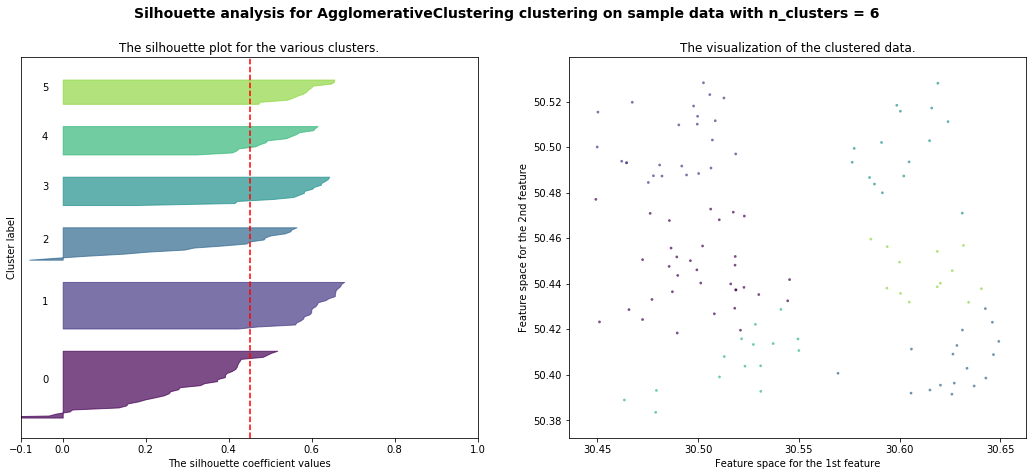

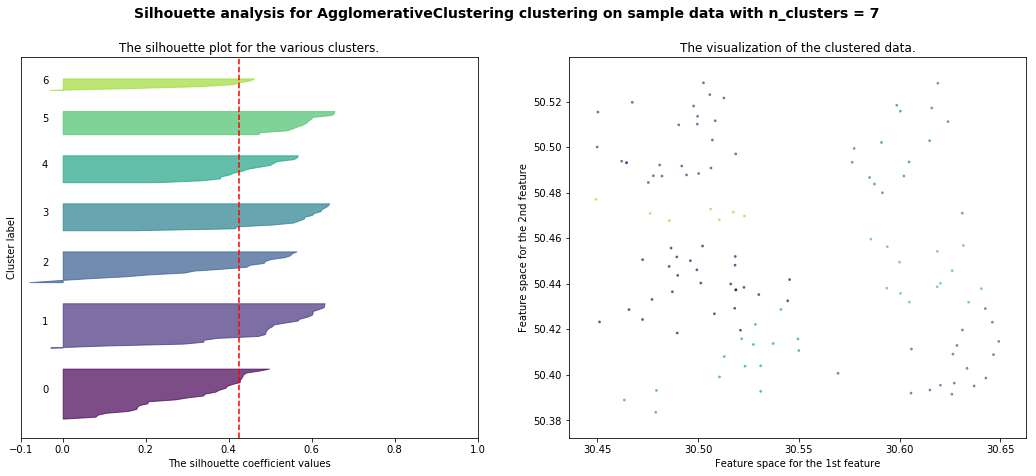

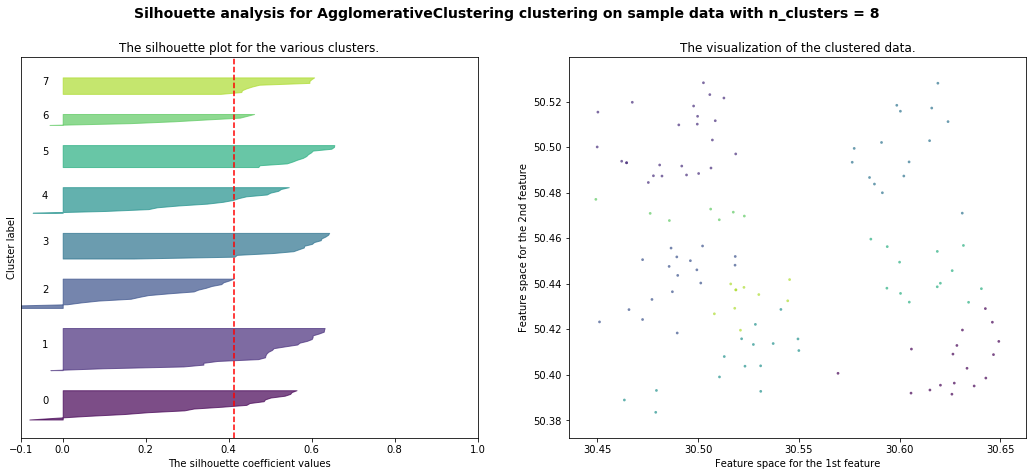

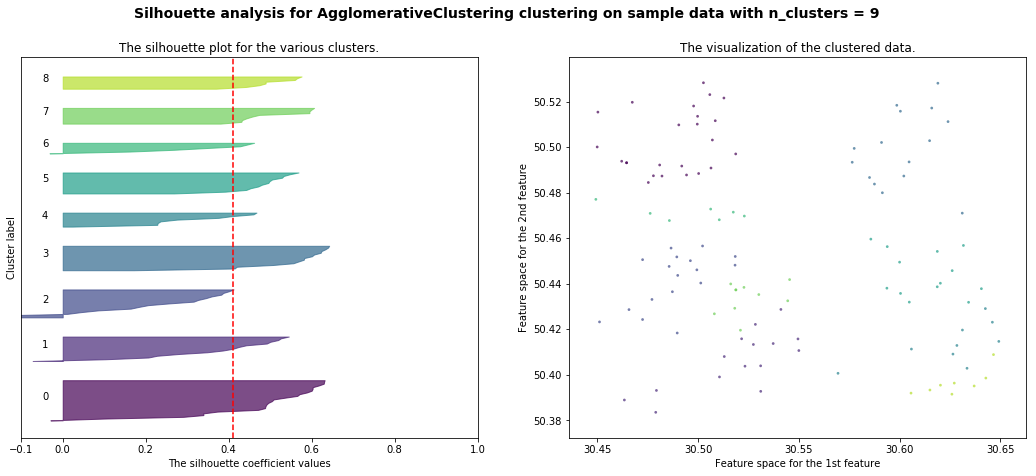

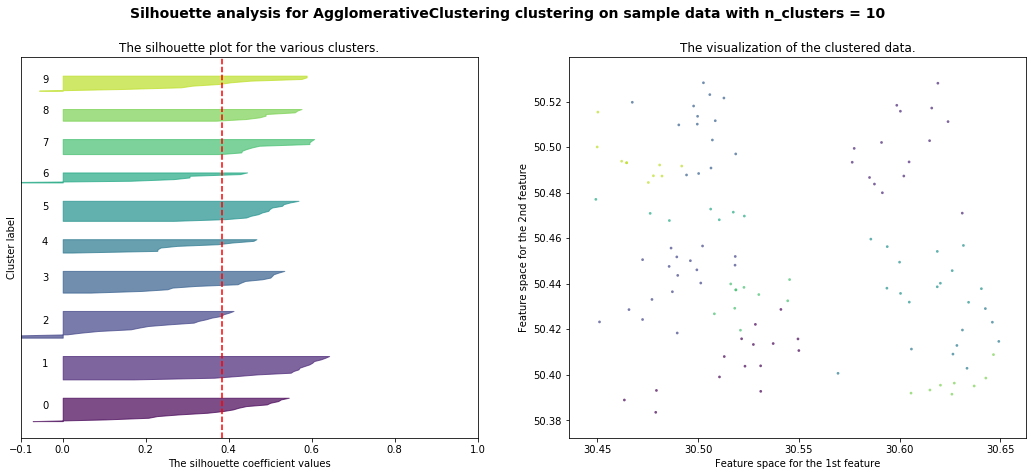

In [60]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.

range_n_clusters = range(2, 11, 1)

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = AgglomerativeClustering(n_clusters = n_clusters).fit(X)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.viridis(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.viridis(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(clusters_df[['lat', 'lon']].iloc[:, 1], clusters_df[['lat', 'lon']].iloc[:, 0], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
#     centers = clusterer.cluster_centers_
#     # Draw white circles at cluster centers
#     ax2.scatter(centers[:, 1], centers[:, 0], marker='o',
#                 c="white", alpha=1, s=200, edgecolor='k')

#     for i, c in enumerate(centers):
#         ax2.scatter(c[1], c[0], marker='$%d$' % i, alpha=1,
#                     s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for AgglomerativeClustering clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

The Silhouette analysis of Agglomerative Clustering for both driving and walking distances hints us that the optimal number of clusters is 4.

In [61]:
n_clusters = 4

<a name="agl_w"></a>
### Agglomerative Clustering for walking distances

In [62]:
X = matrix_walking

In [63]:
from sklearn.cluster import AgglomerativeClustering
clustering = AgglomerativeClustering(n_clusters = n_clusters).fit(X)
clustering

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=4,
            pooling_func=<function mean at 0x10ba4fa60>)

In [64]:
clusters_df['cluster'] = clustering.labels_
clusters_df['color'] = clusters_df['cluster'].apply(calculate_color)
clusters_df.head()

,lat,lon,user_ratings_total,rating,user_ratings_total_scaled,weighted_ratings,cluster,color
0,50.440276,30.501372,417,3.8,0.319540,0.296159,0,#440154
1,50.450083,30.496220,192,4.3,0.147126,0.154303,0,#440154
2,50.424245,30.472491,595,4.2,0.455939,0.467059,0,#440154
3,50.435211,30.530175,115,4.0,0.088123,0.085973,0,#440154
4,50.437261,30.518789,146,4.2,0.111877,0.114606,0,#440154


In [65]:
fig = gmaps.figure(center = (lat, lon), zoom_level = zoom, layout=figure_layout)
for clust in clusters_df['cluster'].unique():
    cluster_layer = gmaps.symbol_layer(
        clusters_df[['lat', 'lon']][clusters_df['cluster'] == clust],
        fill_color = clusters_df['color'][clusters_df['cluster'] == clust].iloc[0],
        stroke_color = clusters_df['color'][clusters_df['cluster'] == clust].iloc[0],
        scale = 3
    )
    fig.add_layer(cluster_layer)

# centers_layer = gmaps.symbol_layer(
#         kmeans.cluster_centers_,
#         fill_color = "#ff007f",
#         stroke_color = "#ff007f",
#         scale = 5)
# fig.add_layer(centers_layer)

fig

Figure(layout=FigureLayout(border='1px solid black', height='800px', padding='1px', width='800px'))

<a name="agl_dr"></a>
### Agglomerative Clustering for driving distances

In [66]:
X = matrix_driving

In [67]:
from sklearn.cluster import AgglomerativeClustering
clustering = AgglomerativeClustering(n_clusters = n_clusters).fit(X)
clustering

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=4,
            pooling_func=<function mean at 0x10ba4fa60>)

In [68]:
clusters_df['cluster'] = clustering.labels_
clusters_df['color'] = clusters_df['cluster'].apply(calculate_color)
clusters_df.head()

,lat,lon,user_ratings_total,rating,user_ratings_total_scaled,weighted_ratings,cluster,color
0,50.440276,30.501372,417,3.8,0.319540,0.296159,0,#440154
1,50.450083,30.496220,192,4.3,0.147126,0.154303,0,#440154
2,50.424245,30.472491,595,4.2,0.455939,0.467059,0,#440154
3,50.435211,30.530175,115,4.0,0.088123,0.085973,0,#440154
4,50.437261,30.518789,146,4.2,0.111877,0.114606,0,#440154


In [69]:
fig = gmaps.figure(center = (lat, lon), zoom_level = zoom, layout=figure_layout)
for clust in clusters_df['cluster'].unique():
    cluster_layer = gmaps.symbol_layer(
        clusters_df[['lat', 'lon']][clusters_df['cluster'] == clust],
        fill_color = clusters_df['color'][clusters_df['cluster'] == clust].iloc[0],
        stroke_color = clusters_df['color'][clusters_df['cluster'] == clust].iloc[0],
        scale = 3
    )
    fig.add_layer(cluster_layer)

# centers_layer = gmaps.symbol_layer(
#         kmeans.cluster_centers_,
#         fill_color = "#ff007f",
#         stroke_color = "#ff007f",
#         scale = 5)
# fig.add_layer(centers_layer)

fig

Figure(layout=FigureLayout(border='1px solid black', height='800px', padding='1px', width='800px'))

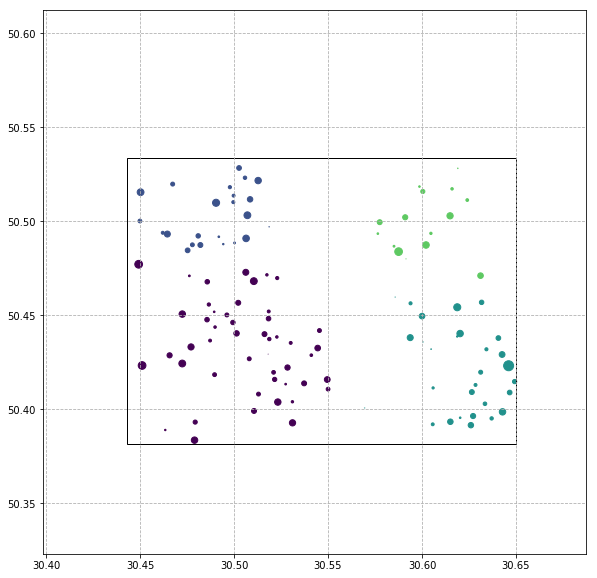

In [70]:
plt.figure(figsize=(20,10))
ax = plt.gca()
ax.cla()
plt.grid(linestyle='--')
plt.ylim(centers['c1'][0] - r1*1.5, centers['c1'][0] + r1*3)
plt.xlim(centers['c1'][1] - r1*1.5, centers['c1'][1] + r1*3)
rectangle = plt.Rectangle((bl[1], bl[0]), width = tr[1] - tl[1], height = tr[0] - br[0], fill = False, color = "black")
ax.set_aspect(1)
size_series = clusters_df['weighted_ratings'] * 100
ax.scatter(clusters_df['lon'], clusters_df['lat'], s = size_series, c = clusters_df['color'])
# ax.scatter(centroids[:, 1], centroids[:, 0], c='pink', s=50)
ax.add_artist(rectangle)
plt.show()

<a name="demand"></a>
## Estimating demand of consumers

Since we do not have any meaningful way of estimating the demand of post office consumers directly, we will try to obtain it via a relatively relatable metric.

We will use the number of ratings as a relative metric of the demand scale. For instance, an office with 50 reviews will have 50 points of demand.

We then assume that 80% of the users is users who frequent the considered post office at least once a week and the other 20% use the post office's services at least once a month.
So for an office with 50 points of demand will be considered to have `0.8 * 50 * 4 (weeks) = 160 + 0.2 * 50 = 170` visitors.

In [71]:
clusters_df['demand'] = clusters_df['user_ratings_total'].apply(lambda x: x * (0.8 * 4 + 0.2))
clusters_df.head()

,lat,lon,user_ratings_total,rating,user_ratings_total_scaled,weighted_ratings,cluster,color,demand
0,50.440276,30.501372,417,3.8,0.319540,0.296159,0,#440154,1417.8
1,50.450083,30.496220,192,4.3,0.147126,0.154303,0,#440154,652.8
2,50.424245,30.472491,595,4.2,0.455939,0.467059,0,#440154,2023.0
3,50.435211,30.530175,115,4.0,0.088123,0.085973,0,#440154,391.0
4,50.437261,30.518789,146,4.2,0.111877,0.114606,0,#440154,496.4


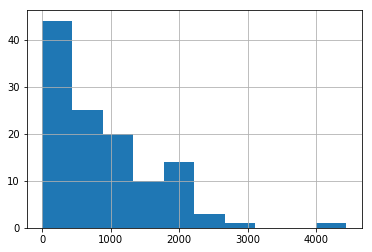

In [72]:
clusters_df['demand'].hist()

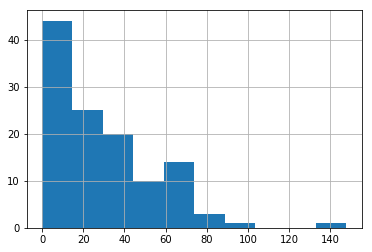

In [73]:
clusters_df['demand_daily'] = clusters_df['demand'] / 30
clusters_df['demand_daily'].hist()

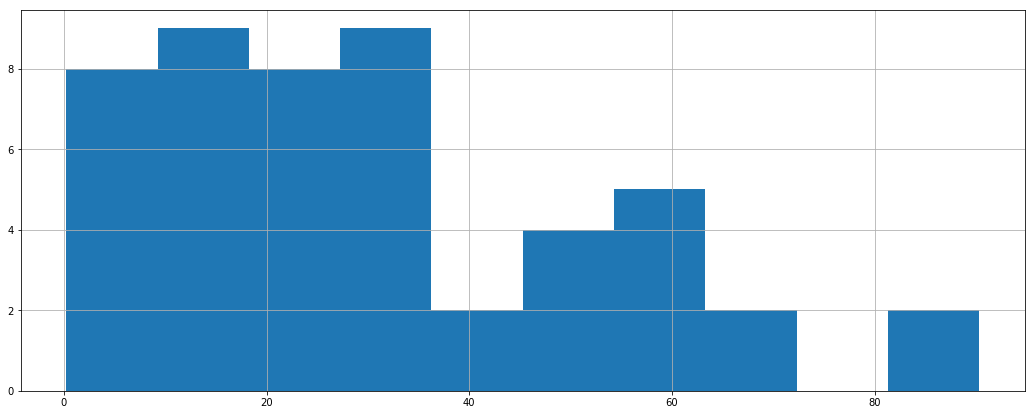

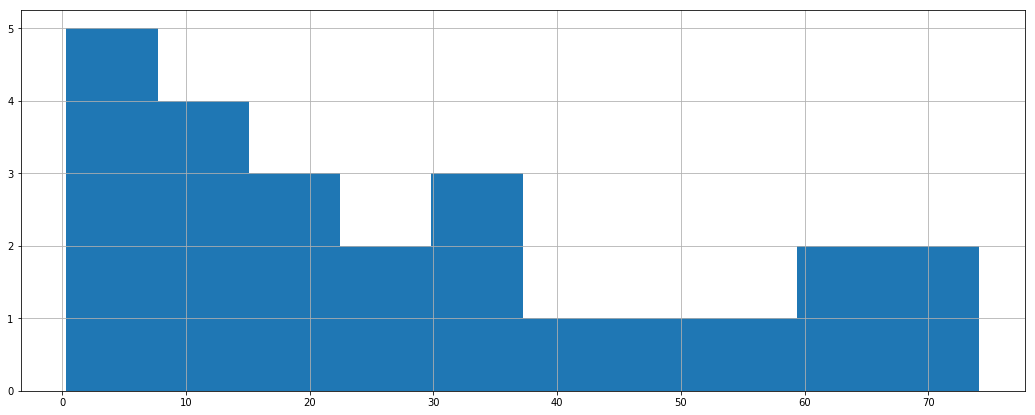

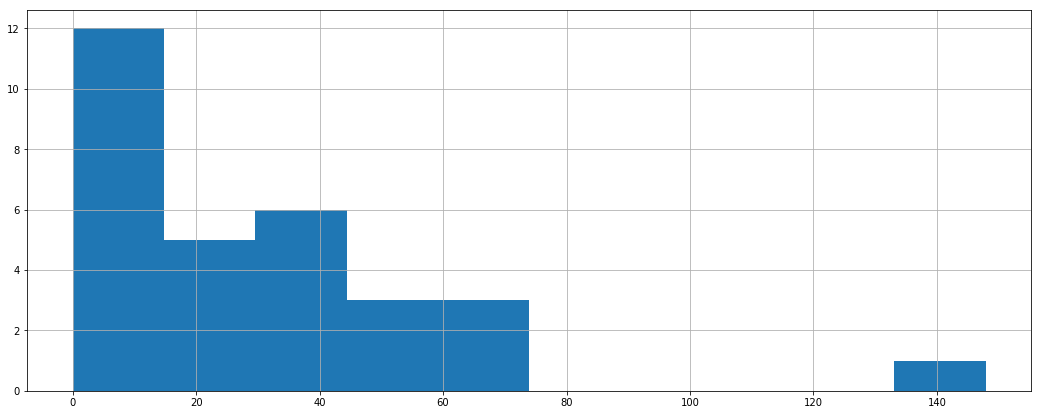

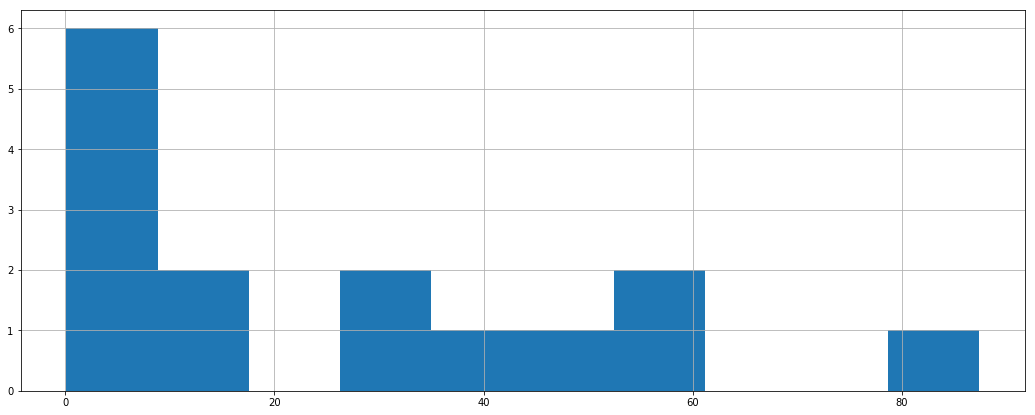

In [74]:
for cluster in clusters_df['cluster'].unique():
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)
    clusters_df['demand_daily'][clusters_df['cluster'] == cluster].hist()

Let's further assume that each user's demand is a 0.7 kg parcel on average. Then the total daily average demand for each cluster, i.e. Satellites, is as follows:

In [75]:
assumed_weight = 0.7

In [76]:
clusters_df[['cluster', 'demand_daily']].groupby("cluster").sum() * assumed_weight

,demand_daily
cluster,
0,1049.104000
1,492.501333
2,617.292667
3,268.226000


In [77]:
clusters_df['demand_daily'].sum() * assumed_weight

2427.124

<a name="vehicles"></a>
### Choosing vehicles for transportation

To address such demand, we have to decide on the types of vehicles that will deliver the parcels from the City Distribution Center to the Satellites, and from there to the individual consumers.

The vehicle for delivering between CDC and S needs to be able to carry up to 3,000 kg of cargo.

The vehicles delivering from Satellites need to be capable of delivering up to 1,100 kg of cargo. However, for smaller deliveries, a load capacity of as small as 300 kg, 650 kg, and 500 kg are required.

To ensure CSR and environmental sustainability, let's first consider fully electric vehicles in order to find those that can potentially fulfill the demand. 

<img src="files/data/fuso.jpg" width="400" height="400" align="left">

##### Mitsubishi Fuso Canter

For deliveries from CDC to Satellites, Mitsubishi Fuso Canter can be considered.
The vehicle is capable of carrying up to 3,000 kg of cargo, and can cover up to 100 km on a single charge. Although the charge is quite small, the Satellites can be equipped with quick chargers, which will be charging the truck during unloading.
The maximum speed of the truck is 90 km/h, which is enough for routes within the city.
It can be charged fully in 7 hours from a regular charger, and in just an hour from a quick charger.

<img src="files/data/tailg.jpg" width="400" height="400" align="left">

##### Electric tricycles TailG

For deliveries from Satellites to customers, compact and mobile all-electric tricycles seem like a perfect option. Their optimal speed is 35 km/h, and they can cover up to 60 km on a single stock battery, but additional compartments for batteries allow to increases this by a factor of 2 or 3. It charges fully within 5-8 hours. The maximum load of the tricycle is 500 kg, which makes it a perfect option for two of the four Satellites.

<img src="files/data/ecaddy.jpg" width="400" height="400" align="left">

##### Volkswagen e-Caddy

For deliveries at higher load Satellites, a small electric cargo vehicle e-Caddy can be considered. Not only its single charge capacity is enough to cover 250 km, but it also has a payload of 636 kg.

Thus, to cover the needs of our consumers, we would need:
* 1 Fuso Canter for CDC
* 3 TailG (1 each for Satellites 1 and 3, and 1 more as a backup for Satellite 0)
* 3 e-Caddy (1 for Satellite 2 and 2 for Satellite 0)

<a name="sat_loc"></a>
### Satellites locations

In order to estimate the candidate locations for the CDC, let's first obtain the locations of Satellites. In order to do so, we perform a K-Means cluster centroid search for each of the clusters obtained by Agglomerative Clustering.

In [79]:
satellites_centroids = {}
for cluster in clusters_df["cluster"].unique():
    num_clusters = 1
    kmeans = KMeans(n_clusters = num_clusters).fit(clusters_df[['lat', 'lon']][clusters_df["cluster"] == cluster])
    satellites_centroids[cluster] = kmeans.cluster_centers_[0]

In [80]:
satellites_centroids

{0: array([50.4333465 , 30.50619528]),
 1: array([50.50253647, 30.48799279]),
 2: array([50.42232394, 30.62077663]),
 3: array([50.49934511, 30.60136474])}

In [81]:
fig = gmaps.figure(center = (lat, lon), zoom_level = zoom, layout=figure_layout)
for clust in clusters_df['cluster'].unique():
    cluster_layer = gmaps.symbol_layer(
        clusters_df[['lat', 'lon']][clusters_df['cluster'] == clust],
        fill_color = clusters_df['color'][clusters_df['cluster'] == clust].iloc[0],
        stroke_color = clusters_df['color'][clusters_df['cluster'] == clust].iloc[0],
        scale = 3
    )
    fig.add_layer(cluster_layer)

centers_layer = gmaps.symbol_layer(
        satellites_centroids.values(),
        fill_color = "#ff007f",
        stroke_color = "#ff007f",
        scale = 5)
fig.add_layer(centers_layer)

fig

Figure(layout=FigureLayout(border='1px solid black', height='800px', padding='1px', width='800px'))

Altough it might seem a little counter-intuitive, the knowledge of the Kyiv city logistics hints us that CDC should be placed either somewhere near Podil region, or alternatively near the Blockbuster Mall.

Let's define the corresponding points and compute the distances to be covered to the Satellites.

In [82]:
podil_cdc = (50.471194, 30.523142)
mall_cdc = (50.486732, 30.519672)

In [83]:
podil_sat_coords = [(x, y) for (x, y) in satellites_centroids.values()] + [podil_cdc]
mall_sat_coords = [(x, y) for (x, y) in satellites_centroids.values()] + [mall_cdc]

In [84]:
loc_podil_matrix = "data/podil_cdc_matrix.npy"
loc_mall_matrix = "data/mall_cdc_matrix.npy"

In [85]:
try:
    podil_driving = np.load(loc_podil_matrix)
except:
    podil_driving = np.empty((len(podil_sat_coords), len(podil_sat_coords)))
    columns = len(podil_sat_coords)
    gmaps_api = googlemaps.Client(key = api_key)
    for row in tqdm(range(len(podil_sat_coords))):
        for column in tqdm(range(columns)):
            origins = (podil_sat_coords[row][0], podil_sat_coords[row][1])
            destination = (podil_sat_coords[column][0], podil_sat_coords[column][1])
    #         print(f"Distance from {origins} to {destination}")
            distance = gmaps_api.distance_matrix(origins, destination, mode='driving')["rows"][0]["elements"][0]["distance"]["value"]
            podil_driving[row, column] = distance
        sleep(5)
    np.save(loc_podil_matrix, podil_driving)

In [86]:
try:
    mall_driving = np.load(loc_mall_matrix)
except:
    mall_driving = np.empty((len(mall_sat_coords), len(mall_sat_coords)))
    columns = len(mall_sat_coords)
    gmaps_api = googlemaps.Client(key = api_key)
    for row in tqdm(range(len(mall_sat_coords))):
        for column in tqdm(range(columns)):
            origins = (mall_sat_coords[row][0], mall_sat_coords[row][1])
            destination = (mall_sat_coords[column][0], mall_sat_coords[column][1])
    #         print(f"Distance from {origins} to {destination}")
            distance = gmaps_api.distance_matrix(origins, destination, mode='driving')["rows"][0]["elements"][0]["distance"]["value"]
            mall_driving[row, column] = distance
        sleep(5)
    np.save(loc_mall_matrix, mall_driving)

<a name="cdc_dist"></a>
## Finding optimal route for both candidate CDCs

### Distance to a CDC candidate located in the Podil region

In [87]:
import mlrose

In [88]:
# Creating list of distances from the previously found assymetric matrix of distances
dist_list = []
for row in range(podil_driving.shape[0]):
    for col in range(podil_driving.shape[1]):
        if row != col:
            dist_tuple = tuple([row, col, podil_driving[row, col]])
            try:
                dist_list.append(dist_tuple)
            except:
                dist_list = [(row, col, podil_driving[row, col])]

In [89]:
dist_list

[(0, 1, 13392.0),
 (0, 2, 13225.0),
 (0, 3, 14145.0),
 (0, 4, 5944.0),
 (1, 0, 11744.0),
 (1, 2, 19312.0),
 (1, 3, 10336.0),
 (1, 4, 7614.0),
 (2, 0, 11573.0),
 (2, 1, 19653.0),
 (2, 3, 11131.0),
 (2, 4, 12205.0),
 (3, 0, 14435.0),
 (3, 1, 11623.0),
 (3, 2, 11656.0),
 (3, 4, 10304.0),
 (4, 0, 6046.0),
 (4, 1, 8319.0),
 (4, 2, 13614.0),
 (4, 3, 12791.0)]

In [90]:
fitness_dists = mlrose.TravellingSales(distances = dist_list)

In [91]:
problem_fit = mlrose.TSPOpt(length = 5, distances = dist_list, maximize = False)

In [92]:
best_state, best_fitness = mlrose.genetic_alg(problem_fit, mutation_prob = 0.2, 
                                              max_attempts = 100, random_state = 2)
print(f'The best state found is: {best_state}')
print(f'The fitness at the best state is: {best_fitness}')

The best state found is: [1 4 0 2 3]
The fitness at the best state is: 49537.0


In [166]:
start_node = 4

In [140]:
positions = np.concatenate((np.array(podil_sat_coords), np.array(podil_sat_coords)))
distances = np.concatenate((np.array(podil_driving), np.array(podil_driving)))
N = 5

In [171]:
full_route = np.append(np.append(best_state[np.where(best_state == starting_node)[0][0]:], best_state[:np.where(best_state == starting_node)[0][0]]), start_node)
full_route

array([4, 0, 2, 3, 1, 4])

Route: [1 4 0 2 3]

Distance: 49537.0


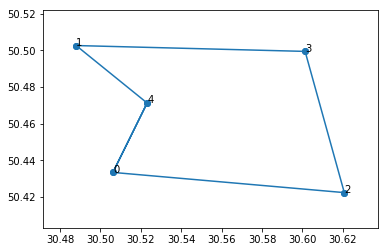

In [174]:
new_cities_order = np.concatenate((np.array([podil_sat_coords[full_route[i]] for i in range(len(full_route))]),np.array([podil_sat_coords[0]])))
# Plot the cities.
fig, ax = plt.subplots()
ax.scatter(positions[:,1],positions[:,0])
for i in range(len((podil_sat_coords))):
    ax.annotate(i, (positions[i][1], positions[i][0]))
# Plot the path.
ax.plot(new_cities_order[:,1], new_cities_order[:,0])
# plt.show()
# Print the route as row numbers and the total distance travelled by the path.
print("Route: " + str(best_state) + "\n\nDistance: " + str(best_fitness))

Now let's perform the same operation for the CDC candidate near Blockbuster Mall.

In [175]:
# Creating list of distances from the previously found assymetric matrix of distances
dist_list = []
for row in range(mall_driving.shape[0]):
    for col in range(mall_driving.shape[1]):
        if row != col:
            dist_tuple = tuple([row, col, mall_driving[row, col]])
            try:
                dist_list.append(dist_tuple)
            except:
                dist_list = [(row, col, mall_driving[row, col])]

In [176]:
dist_list

[(0, 1, 13392.0),
 (0, 2, 13225.0),
 (0, 3, 14145.0),
 (0, 4, 13475.0),
 (1, 0, 11744.0),
 (1, 2, 19312.0),
 (1, 3, 10336.0),
 (1, 4, 3970.0),
 (2, 0, 11573.0),
 (2, 1, 19653.0),
 (2, 3, 11131.0),
 (2, 4, 20595.0),
 (3, 0, 14435.0),
 (3, 1, 11623.0),
 (3, 2, 11656.0),
 (3, 4, 11709.0),
 (4, 0, 8628.0),
 (4, 1, 6191.0),
 (4, 2, 16195.0),
 (4, 3, 6733.0)]

In [177]:
fitness_dists = mlrose.TravellingSales(distances = dist_list)

In [178]:
problem_fit = mlrose.TSPOpt(length = 5, distances = dist_list, maximize = False)

In [179]:
best_state, best_fitness = mlrose.genetic_alg(problem_fit, mutation_prob = 0.2, 
                                              max_attempts = 100, random_state = 2)
print(f'The best state found is: {best_state}')
print(f'The fitness at the best state is: {best_fitness}')

The best state found is: [3 1 4 0 2]
The fitness at the best state is: 55645.0


In [180]:
start_node = 4

In [181]:
positions = np.concatenate((np.array(mall_sat_coords), np.array(mall_sat_coords)))
distances = np.concatenate((np.array(mall_driving), np.array(mall_driving)))
N = 5

In [182]:
full_route = np.append(np.append(best_state[np.where(best_state == starting_node)[0][0]:], best_state[:np.where(best_state == starting_node)[0][0]]), start_node)
full_route

array([4, 0, 2, 3, 1, 4])

Route: [3 1 4 0 2]

Distance: 55645.0


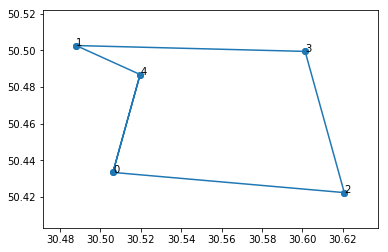

In [183]:
new_cities_order = np.concatenate((np.array([mall_sat_coords[full_route[i]] for i in range(len(full_route))]),np.array([mall_sat_coords[0]])))
# Plot the cities.
fig, ax = plt.subplots()
ax.scatter(positions[:,1],positions[:,0])
for i in range(len((mall_sat_coords))):
    ax.annotate(i, (positions[i][1], positions[i][0]))
# Plot the path.
ax.plot(new_cities_order[:,1], new_cities_order[:,0])
# plt.show()
# Print the route as row numbers and the total distance travelled by the path.
print("Route: " + str(best_state) + "\n\nDistance: " + str(best_fitness))

Evidently, the CDC located near Podil region results in an almost 6 km shorter path.

Thus, we will proceed further with the assumtion that the CDC will be located near **Podil region**.

<a name='cost'></a>
## Defining transportation cost

To recall, we have made a decision to promote all-electric parcel delivery. Thus we need to estimate the cost of 1 km driven.

The average cost of 1 km travelled by an electric vehicle in Ukraine is estimated at $0.05, which is the lowest price one can get for a cargo vehicle.

We will take the cost of 1 km as the only determinant of the variable costs. Since we have the payload capacity of the vehicles as given, the quantity of the total vehicles can be computed. Thus, all other expenses will be considered as either fixed costs or investments (e.g. the purchase of the vehicle).

In [184]:
cost_of_km = 0.05

<a name="scenario_1"></a>
## Scenario 1. 2-Echelon Single Source Location Model

In this scenario we assume that the Satellites act as Pack Stations, i.e. the customers come to them to pick up their parcels.

The problem can then be simplified to a Traveling Salesman Problem, where the City Distribution Center acts as the starting and ending node, and the salesman has to visit each other node on the graph.

We have solved this problem earlier, when we were choosing the proper location for the CDC. To recap:

In [185]:
# Creating list of distances from the previously found assymetric matrix of distances
dist_list = []
for row in range(podil_driving.shape[0]):
    for col in range(podil_driving.shape[1]):
        if row != col:
            dist_tuple = tuple([row, col, podil_driving[row, col]])
            try:
                dist_list.append(dist_tuple)
            except:
                dist_list = [(row, col, podil_driving[row, col])]

In [186]:
dist_list

[(0, 1, 13392.0),
 (0, 2, 13225.0),
 (0, 3, 14145.0),
 (0, 4, 5944.0),
 (1, 0, 11744.0),
 (1, 2, 19312.0),
 (1, 3, 10336.0),
 (1, 4, 7614.0),
 (2, 0, 11573.0),
 (2, 1, 19653.0),
 (2, 3, 11131.0),
 (2, 4, 12205.0),
 (3, 0, 14435.0),
 (3, 1, 11623.0),
 (3, 2, 11656.0),
 (3, 4, 10304.0),
 (4, 0, 6046.0),
 (4, 1, 8319.0),
 (4, 2, 13614.0),
 (4, 3, 12791.0)]

In [187]:
fitness_dists = mlrose.TravellingSales(distances = dist_list)

In [188]:
problem_fit = mlrose.TSPOpt(length = 5, distances = dist_list, maximize = False)

In [189]:
best_state, best_fitness = mlrose.genetic_alg(problem_fit, mutation_prob = 0.2, 
                                              max_attempts = 100, random_state = 2)

In [190]:
start_node = 4

In [191]:
positions = np.concatenate((np.array(podil_sat_coords), np.array(podil_sat_coords)))
distances = np.concatenate((np.array(podil_driving), np.array(podil_driving)))
N = 5

In [192]:
full_route = np.append(np.append(best_state[np.where(best_state == starting_node)[0][0]:], best_state[:np.where(best_state == starting_node)[0][0]]), start_node)
full_route

array([4, 0, 2, 3, 1, 4])

Route: [1 4 0 2 3]

Distance: 49537.0


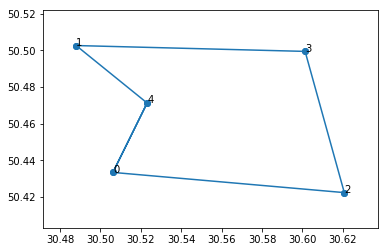

In [193]:
new_cities_order = np.concatenate((np.array([podil_sat_coords[full_route[i]] for i in range(len(full_route))]),np.array([podil_sat_coords[0]])))
# Plot the cities.
fig, ax = plt.subplots()
ax.scatter(positions[:,1],positions[:,0])
for i in range(len((podil_sat_coords))):
    ax.annotate(i, (positions[i][1], positions[i][0]))
# Plot the path.
ax.plot(new_cities_order[:,1], new_cities_order[:,0])
# plt.show()
# Print the route as row numbers and the total distance travelled by the path.
print("Route: " + str(best_state) + "\n\nDistance: " + str(best_fitness))